![intro](./intro.png)

# Project IV. Face Detection and Swap with OpenCV+Dlib
1. Extract faces from a given image (68 landmarks detection)
2. Mesh the faces from two different images
3. Swap the faces of 2 persons

**The code implementation of Face Swap is written by students, while all visualization codes are provided.**

## Setup
Please install required packages and make sure the version are valid 

Installation of dlib library is bit tricky you have to follow some steps:
1. Install **visual studio (2017 or 2022)** - refer to this [link](https://visualstudio.microsoft.com/zh-hans/downloads/)
2. In visual studio one need to install CMake package
3. After installation from Visual studio we have to install it again using - `pip install cmake`
4. Here comes the last part now, we have to install dlib by - `pip install dlib`

### We will start by importing some required libraries.

In [115]:
import cv2
import numpy as np
import dlib
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

### Next we will load two images of different persons, resizing them to (300, 300).

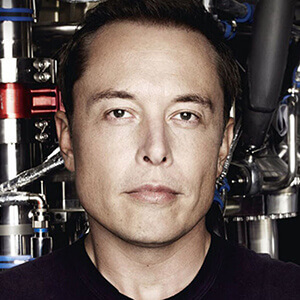

In [116]:
image1 = Image.open('../data/Elon.jpg')
image1 = image1.resize((300,300))
image1

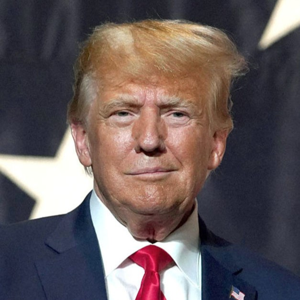

In [117]:
image2 = Image.open('../data/Trump.jpg')
image2 = image2.resize((300,300))
image2 


### Now we will convert our images into numpy array and use cv2 to convert it into grayscale. We will also create empty image or mask similar to our source image with zeros.

In [118]:
# Converting image to array and converting them to grayscale
img1 = np.array(image1)
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = np.array(image2)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

### Load Face detector and Face landmarks predictor using dlib.

In [119]:
# Initalizing frontal face detector and shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("../data/pretrained_weights/shape_predictor_68_face_landmarks.dat")

### the `get_landmarks()` first use `detector` to localize face bbox and then use `predictor` to detect landmarks (68 points, dtype: np.array).

In [120]:
class TooManyFaces(Exception):
    pass

class NoFaces(Exception):
    pass

def get_landmarks(detector, predictor, img):
    faces = detector(img, 1)
    
    if len(faces) > 1:
        raise TooManyFaces
    if len(faces) == 0:
        raise NoFaces
    
    landmarks = [(p.x, p.y) for p in predictor(img, faces[0]).parts()]
    return landmarks

landmarks1 = get_landmarks(detector, predictor, img1)
landmarks2 = get_landmarks(detector, predictor, img2)  
landmarks1

[(70, 122),
 (72, 144),
 (75, 166),
 (77, 187),
 (83, 205),
 (96, 220),
 (112, 231),
 (131, 241),
 (150, 244),
 (167, 242),
 (184, 232),
 (198, 221),
 (208, 207),
 (213, 189),
 (216, 169),
 (220, 149),
 (222, 128),
 (86, 104),
 (96, 94),
 (111, 89),
 (126, 91),
 (141, 97),
 (169, 98),
 (182, 94),
 (196, 94),
 (208, 99),
 (215, 111),
 (156, 114),
 (156, 126),
 (157, 139),
 (157, 151),
 (142, 162),
 (149, 164),
 (155, 166),
 (162, 166),
 (167, 164),
 (107, 115),
 (115, 110),
 (125, 110),
 (133, 117),
 (124, 118),
 (114, 118),
 (173, 119),
 (181, 113),
 (191, 114),
 (198, 120),
 (190, 122),
 (181, 121),
 (125, 193),
 (137, 187),
 (147, 184),
 (154, 186),
 (160, 185),
 (169, 189),
 (179, 195),
 (169, 202),
 (161, 202),
 (154, 202),
 (146, 201),
 (137, 199),
 (131, 193),
 (147, 191),
 (154, 192),
 (160, 192),
 (174, 195),
 (160, 192),
 (154, 192),
 (147, 191)]

### the `get_face_mask()` gets the face mask according landmarks.

In [121]:
def get_face_mask(img, landmarks):
    landmarks_array = np.array(landmarks)
    convexhull = cv2.convexHull(landmarks_array)
    mask = np.zeros(img.shape, dtype=img.dtype)

    if len(img.shape) == 3:
        fill_color = (255, 255, 255)
    else:
        fill_color = 255

    if convexhull is not None and len(convexhull) > 0:
         cv2.fillConvexPoly(mask, convexhull, fill_color)
    else:
        print("Warning: Convex hull is empty or invalid, cannot fill mask.")

    return convexhull, mask

convexhull1, mask1 = get_face_mask(img1_gray, landmarks1)
convexhull2, mask2 = get_face_mask(img2_gray, landmarks2)
mask1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

### the `get_delaunay_triangulation()` gets the face mesh triangulation according landmarks.

In [122]:
def get_delaunay_triangulation(landmarks, convexhull):
    rect = cv2.boundingRect(convexhull)
    subdiv = cv2.Subdiv2D(rect)

    # Insert points into the subdivision
    for p in landmarks:
        # Need to insert as integer tuples
        subdiv.insert((int(p[0]), int(p[1])))

    triangles = []
    # Get triangle list from the subdivision
    triangleList = subdiv.getTriangleList()

    # Find the indices of the points forming each triangle
    points = [(int(p[0]), int(p[1])) for p in landmarks] # Convert landmarks to list of tuples for easier lookup

    for t in triangleList:
        pt1 = (int(t[0]), int(t[1]))
        pt2 = (int(t[2]), int(t[3]))
        pt3 = (int(t[4]), int(t[5]))

        # Find the index of each point in the original landmarks
        # Check if the point is within the convex hull to avoid triangles outside the face
        if cv2.pointPolygonTest(convexhull, pt1, False) >= 0 and \
           cv2.pointPolygonTest(convexhull, pt2, False) >= 0 and \
           cv2.pointPolygonTest(convexhull, pt3, False) >= 0:

            try:
                idx1 = points.index(pt1)
                idx2 = points.index(pt2)
                idx3 = points.index(pt3)
                triangles.append([idx1, idx2, idx3])
            except ValueError:
                # This might happen if the triangulation includes points not exactly matching landmarks
                # For simplicity, we'll skip such triangles in this example
                pass

    return triangles


In [123]:
# Face 1
landmarks1 = get_landmarks(detector, predictor, img1_gray)

# Mask
convexhull1, mask1 = get_face_mask(img1_gray, landmarks1)
face1 = cv2.bitwise_and(img1, img1, mask=mask1)

# Delaunay triangulation
triangles1 = get_delaunay_triangulation(landmarks1, convexhull1)

landmarks1


[(70, 122),
 (73, 144),
 (75, 165),
 (77, 186),
 (83, 205),
 (96, 220),
 (113, 231),
 (132, 240),
 (151, 243),
 (169, 241),
 (185, 231),
 (199, 220),
 (208, 206),
 (213, 188),
 (216, 168),
 (219, 148),
 (222, 128),
 (87, 105),
 (96, 94),
 (111, 89),
 (126, 91),
 (140, 97),
 (169, 99),
 (182, 94),
 (196, 94),
 (208, 99),
 (215, 111),
 (156, 114),
 (156, 126),
 (157, 139),
 (157, 151),
 (142, 162),
 (149, 164),
 (155, 166),
 (162, 165),
 (167, 164),
 (107, 115),
 (116, 110),
 (125, 110),
 (133, 117),
 (124, 118),
 (115, 118),
 (172, 119),
 (181, 113),
 (191, 114),
 (197, 120),
 (190, 122),
 (181, 121),
 (125, 193),
 (137, 188),
 (147, 184),
 (154, 186),
 (161, 185),
 (169, 189),
 (179, 195),
 (169, 202),
 (160, 202),
 (154, 202),
 (146, 201),
 (136, 200),
 (131, 194),
 (147, 191),
 (154, 191),
 (160, 191),
 (174, 195),
 (160, 192),
 (154, 193),
 (147, 192)]

In [124]:
# Face 2
landmarks2 = get_landmarks(detector, predictor, img2_gray)

# Mask
convexhull2, mask2 = get_face_mask(img2_gray, landmarks2)
face2 = cv2.bitwise_and(img2, img2, mask=mask2)

# Delaunay triangulation
triangles2 = get_delaunay_triangulation(landmarks2, convexhull2)

print(f"Max value in mask1: {np.max(face2)}")
triangles2

Max value in mask1: 249


[[36, 0, 17],
 [0, 36, 1],
 [52, 33, 34],
 [33, 52, 51],
 [29, 31, 39],
 [31, 29, 30],
 [2, 1, 31],
 [2, 31, 48],
 [3, 2, 48],
 [36, 17, 18],
 [4, 3, 48],
 [54, 10, 55],
 [10, 54, 11],
 [5, 4, 48],
 [6, 5, 48],
 [37, 18, 19],
 [18, 37, 36],
 [7, 6, 59],
 [35, 30, 29],
 [30, 35, 34],
 [8, 7, 58],
 [9, 8, 57],
 [10, 9, 55],
 [37, 38, 40],
 [38, 37, 19],
 [14, 45, 15],
 [45, 14, 46],
 [12, 11, 54],
 [27, 21, 22],
 [21, 27, 39],
 [13, 12, 54],
 [14, 13, 54],
 [38, 20, 39],
 [20, 38, 19],
 [16, 15, 45],
 [24, 20, 19],
 [20, 24, 23],
 [54, 35, 14],
 [35, 54, 64],
 [35, 29, 42],
 [44, 46, 47],
 [46, 44, 45],
 [20, 23, 21],
 [21, 23, 22],
 [20, 21, 39],
 [28, 42, 29],
 [42, 28, 27],
 [42, 27, 22],
 [43, 24, 44],
 [24, 43, 23],
 [42, 22, 23],
 [42, 23, 43],
 [16, 45, 26],
 [24, 25, 44],
 [25, 26, 45],
 [31, 1, 41],
 [1, 36, 41],
 [49, 31, 50],
 [31, 49, 48],
 [27, 28, 39],
 [58, 62, 57],
 [62, 58, 61],
 [50, 31, 32],
 [28, 29, 39],
 [62, 56, 57],
 [56, 62, 63],
 [7, 59, 58],
 [61, 59, 49],
 [59

### Face Detection and Landmark Detection Visualization

In [125]:
def visulize_face_landmarks(img, mask, landmarks, triangles):
    plt.figure(figsize=(100, 300))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    face = cv2.bitwise_and(img, img, mask=mask)
    plt.imshow(face)
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    img_landmark = img.copy()
    
    for triangle_indices in triangles:
        triangle_coords = np.array([landmarks[i] for i in triangle_indices], np.int32)
        cv2.polylines(img_landmark, [triangle_coords.reshape((-1, 1 ,2))], True, (255, 255, 255), 1)
    
    for i, (x, y) in enumerate(landmarks):
        cv2.circle(img_landmark, (x, y), 3, (0, 255, 0), -1)

    
    plt.imshow(img_landmark)
    plt.axis('off')
    
    plt.show()

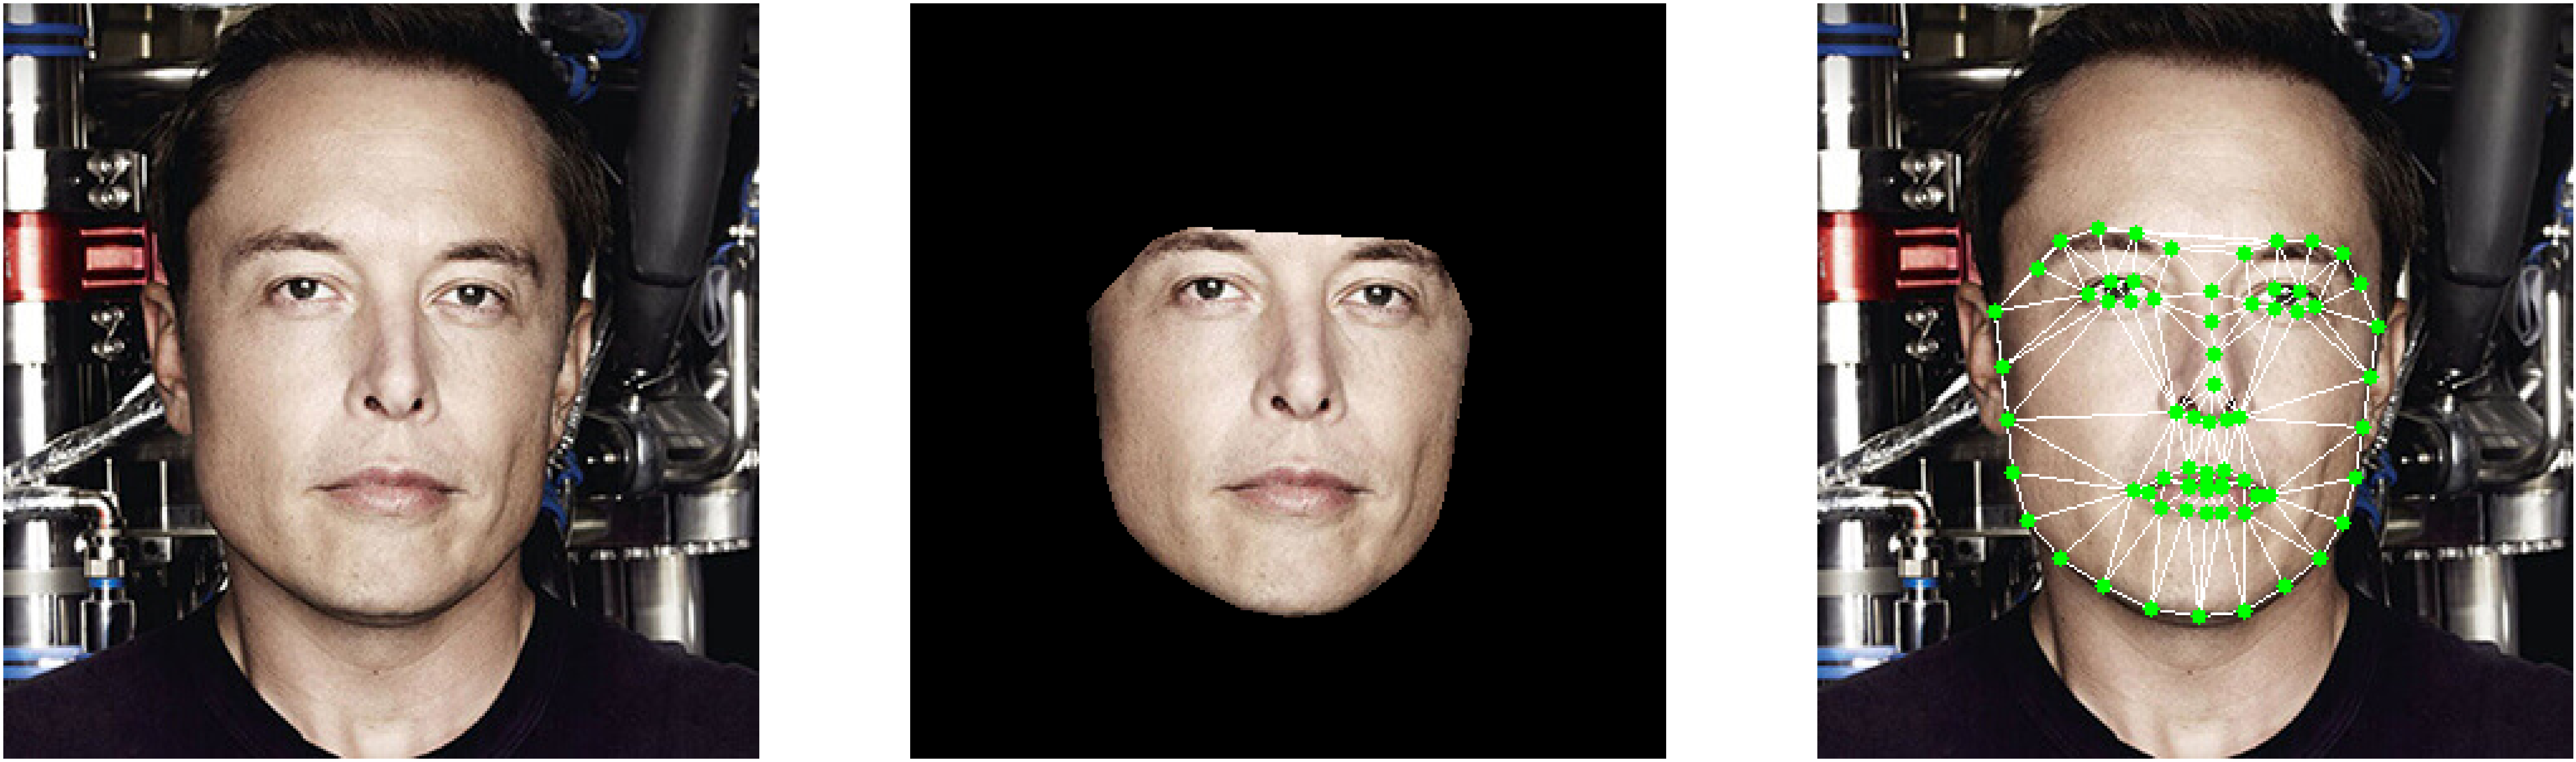

In [126]:
visulize_face_landmarks(img1, mask1, landmarks1, triangles1)

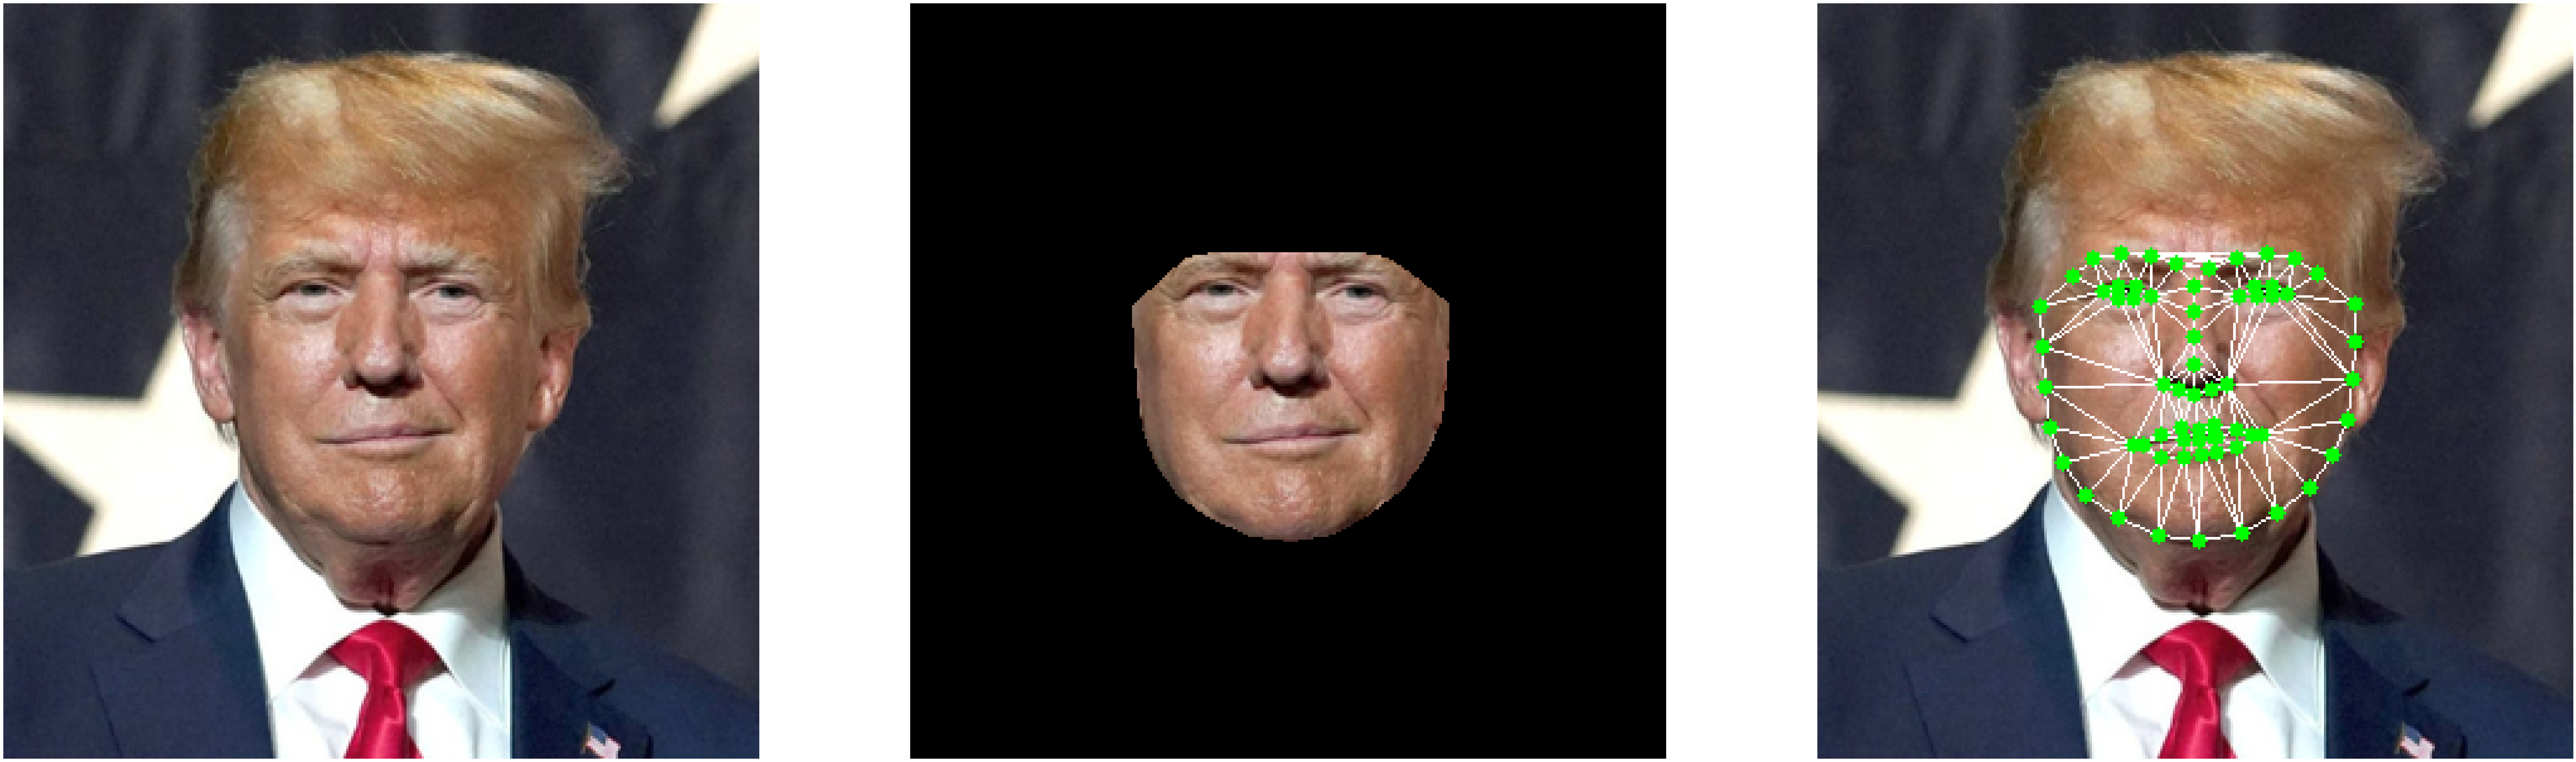

In [127]:
visulize_face_landmarks(img2, mask2, landmarks2, triangles2)

### `transformation_from_points()` calculate the affine transformation matrix M to warp the face of person2 to match person1.

In [128]:
def transformation_from_landmarks(landmarks1, landmarks2):
    """
    Return an affine transformation [s * R | T] such that:
        sum ||s*R*p1,i + T - p2,i||^2
    is minimized.
    """
    # Solve the procrustes problem by subtracting centroids, scaling by the
    # standard deviation, and then using the SVD to calculate the rotation. See
    # the following for more details:
    #   https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem
    
    # Your Code here
    
    M, _ = cv2.estimateAffinePartial2D(np.array(landmarks1), np.array(landmarks2))
    return M

M = transformation_from_landmarks(landmarks1, landmarks2)
M

array([[ 7.78326648e-01,  4.39748091e-03,  3.08742396e+01],
       [-4.39748091e-03,  7.78326648e-01,  2.42637846e+01]])

`warp_img` utilize the affine transformation matrix M to transform the img

In [129]:
def warp_img(img, M, dshape):
    # Perform the affine transformation
    warped_img = cv2.warpAffine(img, M, (dshape[1], dshape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

    # If the warped image is single channel but the target shape is 3-channel,
    # convert the warped image to 3 channels by duplicating the single channel.
    if len(warped_img.shape) == 2 and len(dshape) == 3:
        warped_img = cv2.cvtColor(warped_img, cv2.COLOR_GRAY2BGR)
        
    return warped_img

### swap the face of person1 to match person2

In [130]:
'''
img2: target img (person2)
warped_img1: warped face img of person1
face_mask1: warped face mask of person1
'''
img1_float = img1.astype(np.float32)
mask1_float = mask1.astype(np.float32)
img2_float = img2.astype(np.float32)

# Warp the color image img1 and the mask mask1
# The modified warp_img will handle the mask's channel dimension if needed
warped_img1 = warp_img(img1_float, M, img2_float.shape)
face_mask1 = warp_img(mask1_float, M, img2_float.shape)

# Ensure the warped mask is binary (0 or 1) and is float32
# Since warp_img is modified to output 3 channels if dshape is 3-channel,
# the mask should now be (height, width, 3)
face_mask1_float = (face_mask1 > 0.5).astype(np.float32)

# Perform blending using the float32 images and the 3-channel float mask
output_img_float = img2_float * (1.0 - face_mask1_float) + warped_img1 * face_mask1_float

# Clip the result to [0, 255] and convert back to uint8 for display
output_img = np.clip(output_img_float, 0, 255).astype(np.uint8)

plt.imshow(output_img)



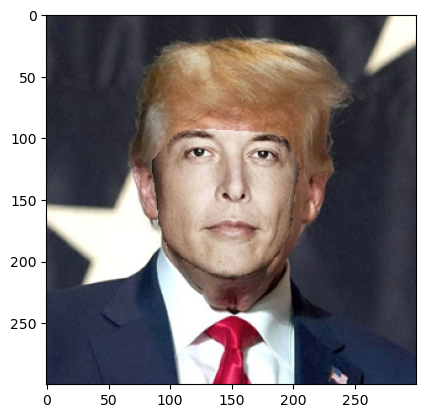

In [131]:
'''
img2: target img (person2)
warped_img1: warped face img of person1
face_mask1: warped face mask of person1
'''
img1_float = img1.astype(np.float32)
mask1_float = mask1.astype(np.float32)
img2_float = img2.astype(np.float32)

# Warp the color image img1 and the mask mask1
# The modified warp_img will handle the mask's channel dimension if needed
warped_img1 = warp_img(img1_float, M, img2_float.shape)
face_mask1 = warp_img(mask1_float, M, img2_float.shape)

# Ensure the warped mask is binary (0 or 1) and is float32
# Since warp_img is modified to output 3 channels if dshape is 3-channel,
# the mask should now be (height, width, 3)
face_mask1_float = (face_mask1 > 0.5).astype(np.float32)

# Perform blending using the float32 images and the 3-channel float mask
output_img_float = img2_float * (1.0 - face_mask1_float) + warped_img1 * face_mask1_float

# Clip the result to [0, 255] and convert back to uint8 for display
output_img = np.clip(output_img_float, 0, 255).astype(np.uint8)

plt.imshow(output_img)
plt.show()


### (Optional) On Opencv we have a built-in function called “seamlessClone” that does this operation automatically. We need to take the swapped face, take the original destination image and it’s mask to cut out the face, we need to get the center of the face.

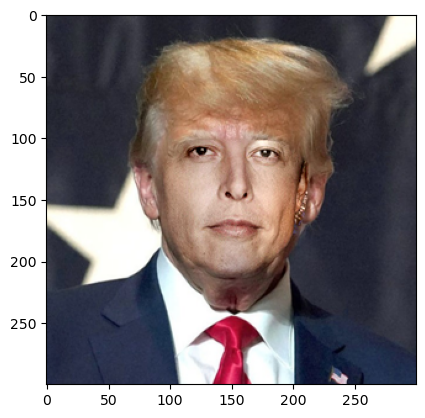

In [134]:
# Your Code here
center = ((int(convexhull2.mean(axis=0)[0][0]), int(convexhull2.mean(axis=0)[0][1])))
seamlessclone = cv2.seamlessClone(warped_img1, img2, mask2, center, cv2.NORMAL_CLONE)
plt.imshow(seamlessclone)
plt.show()